# Visualize how different surface type contributes to the overall flux

In [ ]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pickle
import cloudpickle

import pymc as pm
import arviz as az

from py_markdown_table.markdown_table import markdown_table

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data and models

In [ ]:
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [ ]:
env_data = xr.open_dataset(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2022_20240607.nc')

In [ ]:
with open('models/full_model_n2o_st9_mutable.pkl','rb') as buff:
    model_n2o = cloudpickle.load(buff)

with open('models/full_model_ch4_st6_mutable.pkl','rb') as buff:
    model_ch4 = cloudpickle.load(buff)

In [ ]:
st_labels_9 = np.array(['Base','Dead wood','Harvest residue','Exposed peat','Litter','Bottom layer\n(mosses)','Field layer','Ditch\n(water surface)', 'Living tree', 'Plant\ncovered\nditch'])
st_labels_6 = np.array(['Base', 'Exposed peat', 'Ditch\n(water surface)', 'Plant\ncovered ditch', 'Dead wood\nand residue', 'Litter', 'Field layer\nand trees',])

# full_ch4_st6['model_res']['posterior']['st'] = st_labels_6

# full_n2o_st9['model_res']['posterior']['st'] = st_labels_9

In [ ]:
full_model_eq = lambda T,X,params: params['alpha'] + params['beta']*((T-10)/10) + np.sum(params['gamma']*X + params['delta']*((T-10)/10)*X)

In [ ]:
model_ch4['map']['gamma']

array([ 0.7543145 , -1.73627701,  5.99350395, -0.49649527,  0.54238841,
       -0.38831585])

In [ ]:
def get_params_until(map_params, stop: int) -> dict:

    params = {}
    params['alpha'] = map_params['alpha']
    params['beta'] = map_params['beta']

    params['gamma'] = map_params['gamma'][:stop]
    params['delta'] = map_params['delta'][:stop]

    params['sigma'] = map_params['sigma']

    return params

# N2O plot

In [ ]:
colors_sitemap = np.array([[0,0,256], [70,70,70],
[189,189,189],
[164,114,20],
[223,196,134],
[161,217,155],
[69,193,90],
[31,120,180],
[9,129,1],
[166,206,227]])/256

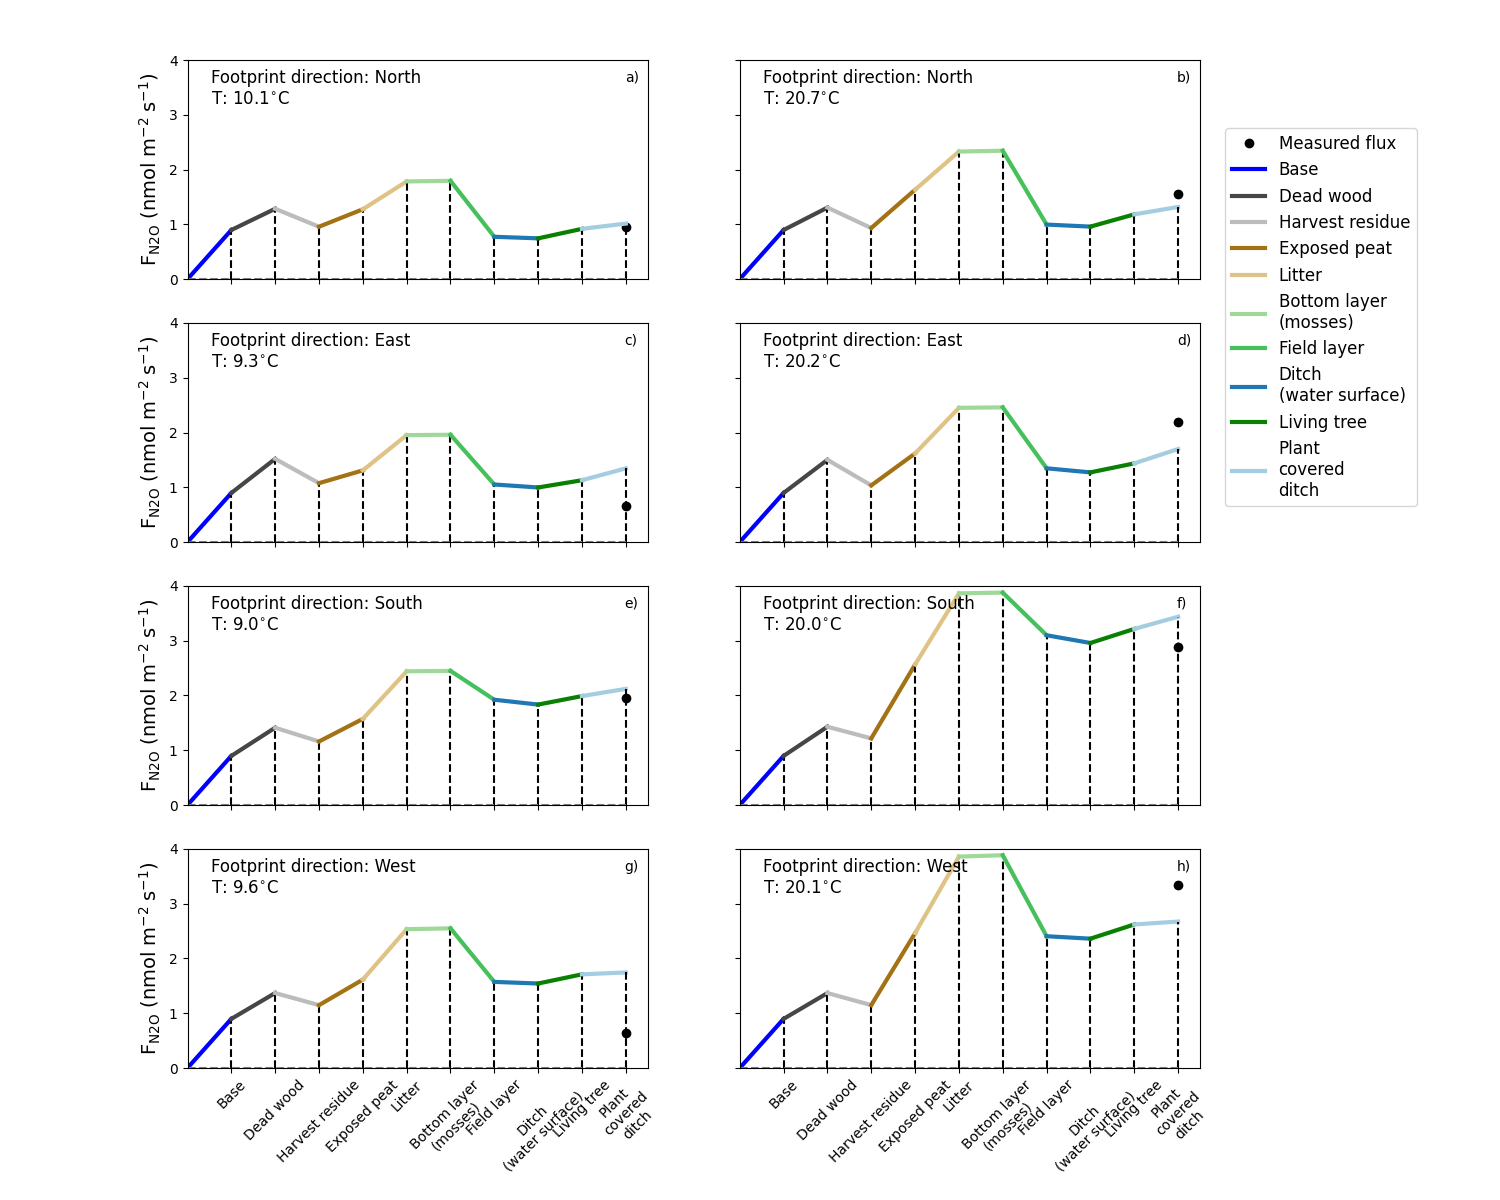

In [ ]:
target_wind_dirs = [0, 90, 180, 270]
target_wind_dir_names = ['North','East','South','West']
target_temperatures = [10, 20]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,12), sharex=True, sharey=True)
fig.subplots_adjust(top=0.95, right=0.8)
subplot_labels=[['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)']]
for i, target_wd in enumerate(target_wind_dirs):
    for j, target_T in enumerate(target_temperatures):
        if target_wd == 0:
            target_wd_left = 359
            target_wd_right = 1
            wind_dir_mask = ((env_data.wind_dir > target_wd_left) | (env_data.wind_dir < target_wd_right))
        else:
            target_wd_left = target_wd-1
            target_wd_right = target_wd+1
            wind_dir_mask = ((env_data.wind_dir > target_wd_left) & (env_data.wind_dir < target_wd_right))

        target_T_left = target_T - 1
        target_T_right = target_T + 1
        env_data_temp = env_data.sel(time=(wind_dir_mask & (env_data.TA_1_1_1 < target_T_right) & (env_data.TA_1_1_1 > target_T_left)))
        T_data = pd.DataFrame(index = env_data_temp.time, columns=['Tair'], data=env_data_temp.TA_1_1_1)
        X_df = pd.DataFrame(index=env_data_temp.time, columns=env_data_temp.soil_class, data=env_data_temp.fpr_contribution.data.T)
        X_df = X_df.assign(Tair = T_data['Tair'].values)
        X_data = X_df.dropna()
        T_data = X_data['Tair'].values
        X_data = X_data.drop(columns=['Instruments','Tair'])
        ind = np.argmin(np.abs(T_data-target_T))
        # print(ind)
        # print(X_data.shape)
        # print(T_data.shape)
        X = X_data.iloc[ind, :].values
        T = env_data_temp.TA_1_1_1[ind].data.flatten()[0]

        real_value = env_data_temp.n2o_flux_final.data[ind]
        if i==0 and j == 0:
            axs[i,j].plot(20, real_value*1000, 'ko', label='Measured flux')
        else:
            axs[i,j].plot(20, real_value*1000, 'ko')

        axs[i,j].set_ylim([0, 4])
        axs[i,j].set_xlim([0, 21])
        axs[i,j].set_xticks(np.linspace(2,20,10))
        if i==3:
            axs[i,j].set_xticklabels(st_labels_9, rotation=45, fontsize=10)
        if j==0:
            axs[i,j].set_ylabel('F$_{\mathrm{N2O}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=14)
        model_values = [0]
        pp = get_params_until(model_n2o['map'], 0)
        model_value_temp = full_model_eq(T, [], pp)
        model_values.append((np.exp(model_value_temp + pp['sigma'].flatten()[0]**2.0/2.0)))
        for st_i in range(9):
            pp = get_params_until(model_n2o['map'], st_i+1)
            model_value_temp = full_model_eq(T, X[:st_i+1], pp)
            model_values.append((np.exp(model_value_temp + pp['sigma'].flatten()[0]**2.0/2.0)))

        x_values = np.linspace(0,20,11)
        for sb_i, value in enumerate(model_values[:-1]):
            if i==0 and j == 0:
                axs[i,j].plot((x_values[sb_i], x_values[sb_i+1]), (value, model_values[sb_i+1]), color=colors_sitemap[sb_i, :], linewidth=3, label=st_labels_9[sb_i])
            else:
                axs[i,j].plot((x_values[sb_i], x_values[sb_i+1]), (value, model_values[sb_i+1]), color=colors_sitemap[sb_i, :], linewidth=3)
            axs[i,j].plot((x_values[sb_i+1], x_values[sb_i+1]), (0, model_values[sb_i+1]), 'k--')
            
        axs[i,j].text(0.05, 0.8, f'Footprint direction: {target_wind_dir_names[i]} \nT: {np.round(T,1)}$^{{\circ}}$C',transform=axs[i,j].transAxes, fontsize=12)
        axs[i,j].text(0.95, 0.9, subplot_labels[i][j], transform=axs[i,j].transAxes)
        axs[i,j].plot((0, 20), (0, 0), '--', color='gray')
        #del X_df, X_data
fig.legend(bbox_to_anchor=(0.5, 0.5, 0.45, 0.4), fontsize=12)


In [ ]:
colors_sitemap_st_6 = np.array([[0,0,256],
                                [164, 114, 20],
                               [31, 120, 180],
                               [166, 206, 227],
                               [129.5, 129.5, 129.5],
                               [223, 196, 134],
                               [39.,  161.,   45.5]
                               ])/256

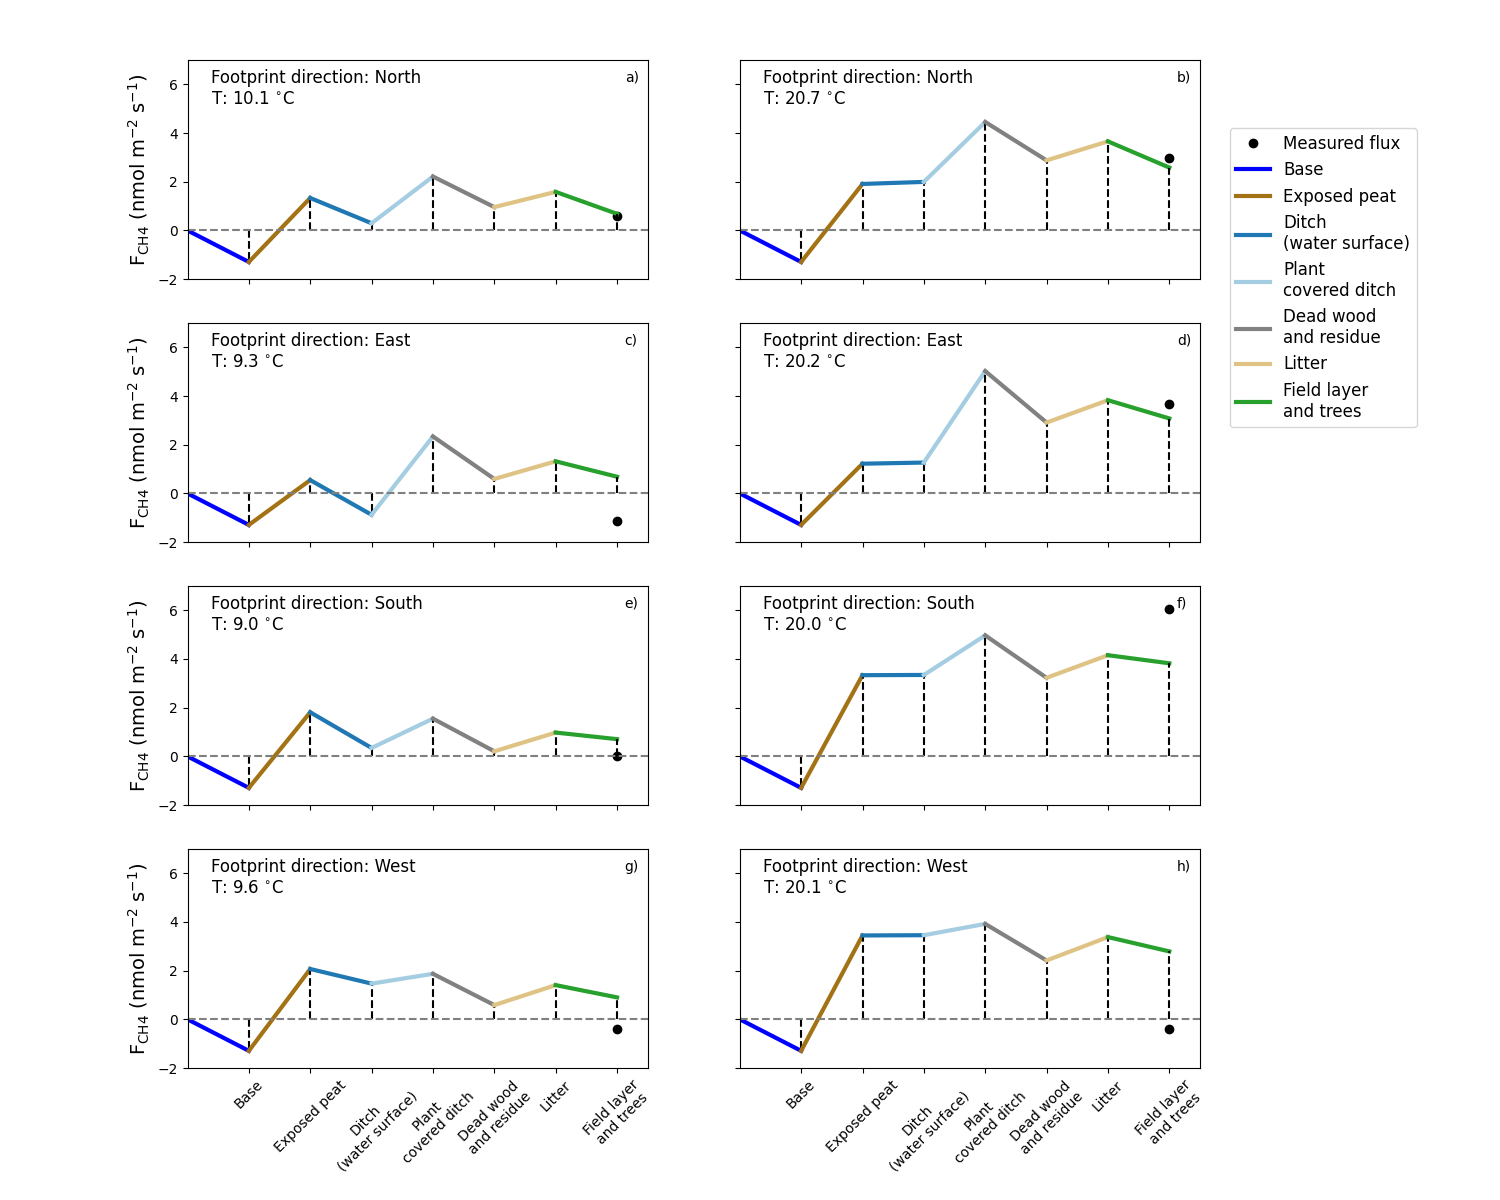

In [ ]:
target_wind_dirs = [0, 90, 180, 270]
target_wind_dir_names = ['North','East','South','West']
target_temperatures = [10, 20]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,12), sharex=True, sharey=True)
fig.subplots_adjust(top=0.95, right=0.8)
subplot_labels=[['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)']]
for i, target_wd in enumerate(target_wind_dirs):
    for j, target_T in enumerate(target_temperatures):
        if target_wd == 0:
            target_wd_left = 359
            target_wd_right = 1
            wind_dir_mask = ((env_data.wind_dir > target_wd_left) | (env_data.wind_dir < target_wd_right))
        else:
            target_wd_left = target_wd-1
            target_wd_right = target_wd+1
            wind_dir_mask = ((env_data.wind_dir > target_wd_left) & (env_data.wind_dir < target_wd_right))

        target_T_left = target_T - 1
        target_T_right = target_T + 1
        env_data_temp = env_data.sel(time=(wind_dir_mask & (env_data.TA_1_1_1 < target_T_right) & (env_data.TA_1_1_1 > target_T_left)))
        T_data = pd.DataFrame(index = env_data_temp.time, columns=['Tair'], data=env_data_temp.TA_1_1_1)
        X_df = pd.DataFrame(index=env_data_temp.time, columns=env_data_temp.soil_class, data=env_data_temp.fpr_contribution.data.T)
        X_df = X_df.assign(Tair = T_data['Tair'].values)
        X_data = X_df.dropna()
        T_data = X_data['Tair'].values
        X_data = X_data.drop(columns=['Instruments','Tair'])

        X_data_combined = X_data.loc[:, ['Exposed peat','Ditch','Covered ditch','Light moss']]
        X_data_combined.insert(3, 'Dead wood and residue', X_data.loc[:, 'Fallen tree'] + X_data.loc[:, 'Dry branch'])
        X_data_combined['Field layer and trees'] = X_data.loc[:, 'Green vegetation'] + X_data.loc[:, 'Tree']
        
        ind = np.argmin(np.abs(T_data-target_T))

        X = X_data_combined.iloc[ind, :].values
        T = env_data_temp.TA_1_1_1[ind].data.flatten()[0]

        real_value = env_data_temp.ch4_flux_final.data[ind]
        if i==0 and j == 0:
            axs[i,j].plot(14, real_value*1000, 'ko', label='Measured flux')
        else:
            axs[i,j].plot(14, real_value*1000, 'ko')

        axs[i,j].set_ylim([-2, 7])
        axs[i,j].set_xlim([0, 15])
        axs[i,j].set_xticks(np.linspace(2,14,7))
        if i==3:
            axs[i,j].set_xticklabels(st_labels_6, rotation=45, fontsize=10)
        if j==0:
            axs[i,j].set_ylabel('F$_{\mathrm{CH4}}$ ($\mathrm{nmol \; m^{-2} \; s^{-1}}$)', fontsize=14)
        model_values = [0]
        pp = get_params_until(model_ch4['map'], 0)
        model_value_temp = full_model_eq(T, [], pp)
        model_values.append((np.exp(model_value_temp + pp['sigma'].flatten()[0]**2.0/2.0)-10))
        for st_i in range(6):
            pp = get_params_until(model_ch4['map'], st_i+1)
            model_value_temp = full_model_eq(T, X[:st_i+1], pp)
            model_values.append((np.exp(model_value_temp + pp['sigma'].flatten()[0]**2.0/2.0)-10))

        x_values = np.linspace(0,14,8)
        for sb_i, value in enumerate(model_values[:-1]):
            if i==0 and j == 0:
                axs[i,j].plot((x_values[sb_i], x_values[sb_i+1]), (value, model_values[sb_i+1]), color=colors_sitemap_st_6[sb_i, :], linewidth=3, label=st_labels_6[sb_i])
            else:
                axs[i,j].plot((x_values[sb_i], x_values[sb_i+1]), (value, model_values[sb_i+1]), color=colors_sitemap_st_6[sb_i, :], linewidth=3)
            axs[i,j].plot((x_values[sb_i+1], x_values[sb_i+1]), (0, model_values[sb_i+1]), 'k--')
            
        axs[i,j].text(0.05, 0.8, f'Footprint direction: {target_wind_dir_names[i]} \nT: {np.round(T,1)} $^{{\circ}}$C',transform=axs[i,j].transAxes, fontsize=12)
        axs[i,j].text(0.95, 0.9, subplot_labels[i][j], transform=axs[i,j].transAxes)
        axs[i,j].plot((0, 20), (0, 0), '--', color='gray')
        #del X_df, X_data
fig.legend(bbox_to_anchor=(0.5, 0.5, 0.45, 0.4), fontsize=12)


In [ ]:
np.linspace(0,14,8)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.])

In [ ]:
xs[i,j].plot((x_values[sb_i], x_values[sb_i+1]), (value, model_values[sb_i+1]), color=colors_sitemap_st_6[sb_i, :], linewidth=3, label=st_labels_6[sb_i])

NameError: name 'xs' is not defined

In [ ]:
x_values

array([ 0.,  2.,  4.,  6.,  8., 10., 12.])